# Introduction

## Aim

Analyze and plot hyperparameter tuning for each algorithm

## Prerequisites

Run the `tune_optimizer` from the `training` module and save the output in a `.json` file in `res` folder.

## Imports

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
from pathlib import Path

path_benchmark = Path('res')

if not path_benchmark.exists():
    raise ValueError

if len(tuple(path_benchmark.iterdir())) == 0:
    raise ValueError('no hyperparameter tuning data')

## Setup code for benchmark analysis 

In [3]:
import json

def load_res_file(fname: str, drop_cst_param: bool = True):
    """Returns a DataFrame from the tuning results and the columns of the DataFrame corresponding to hyperparameters."""
    fpath = path_benchmark.joinpath(f'{fname}.json')
    with open(fpath, 'r') as f:
        res = json.load(f)
        
    df = pd.DataFrame(res)
    hyperparams = df.columns.drop(['loss_train', 'metric_train', 'loss_test', 'metric_test'])
    # Average over folds
    df.loss_train = df.loss_train.apply(lambda e: np.array(e).mean(axis=0))
    df.metric_train = df.metric_train.apply(lambda e: np.array(e).mean(axis=0))
    df.loss_test = df.loss_test.apply(np.mean)
    df['metric_test_std'] = df.metric_test.apply(np.std)
    df.metric_test = df.metric_test.apply(np.mean)
    
    if drop_cst_param:
        hyperparams = hyperparams.drop([e for e in hyperparams if df[e].nunique() <= 1])
    
    return df, hyperparams

# Adam Optimizer

## Coarse grid

In [4]:
# Load results
df, params = load_res_file('adam_tuning_round1')
params

Index(['lr', 'beta1', 'beta2', 'weight_decay', 'epsilon'], dtype='object')

The coarse grid contains 243 combinations of hyperparameters:

In [5]:
df.shape

(243, 11)

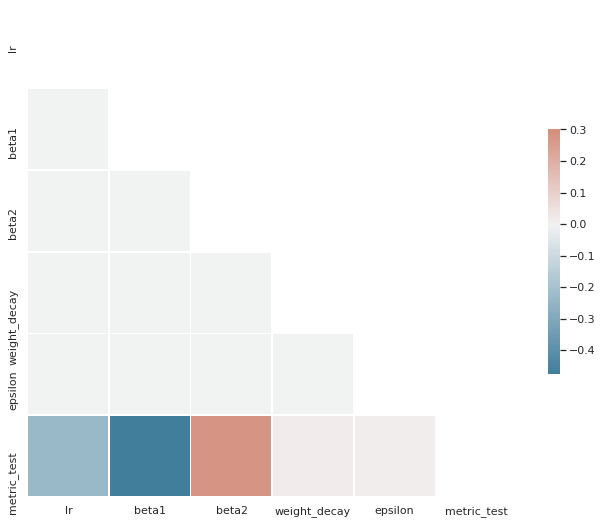

In [6]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Compute the correlation matrix
corr = df[params.tolist() + ['metric_test']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

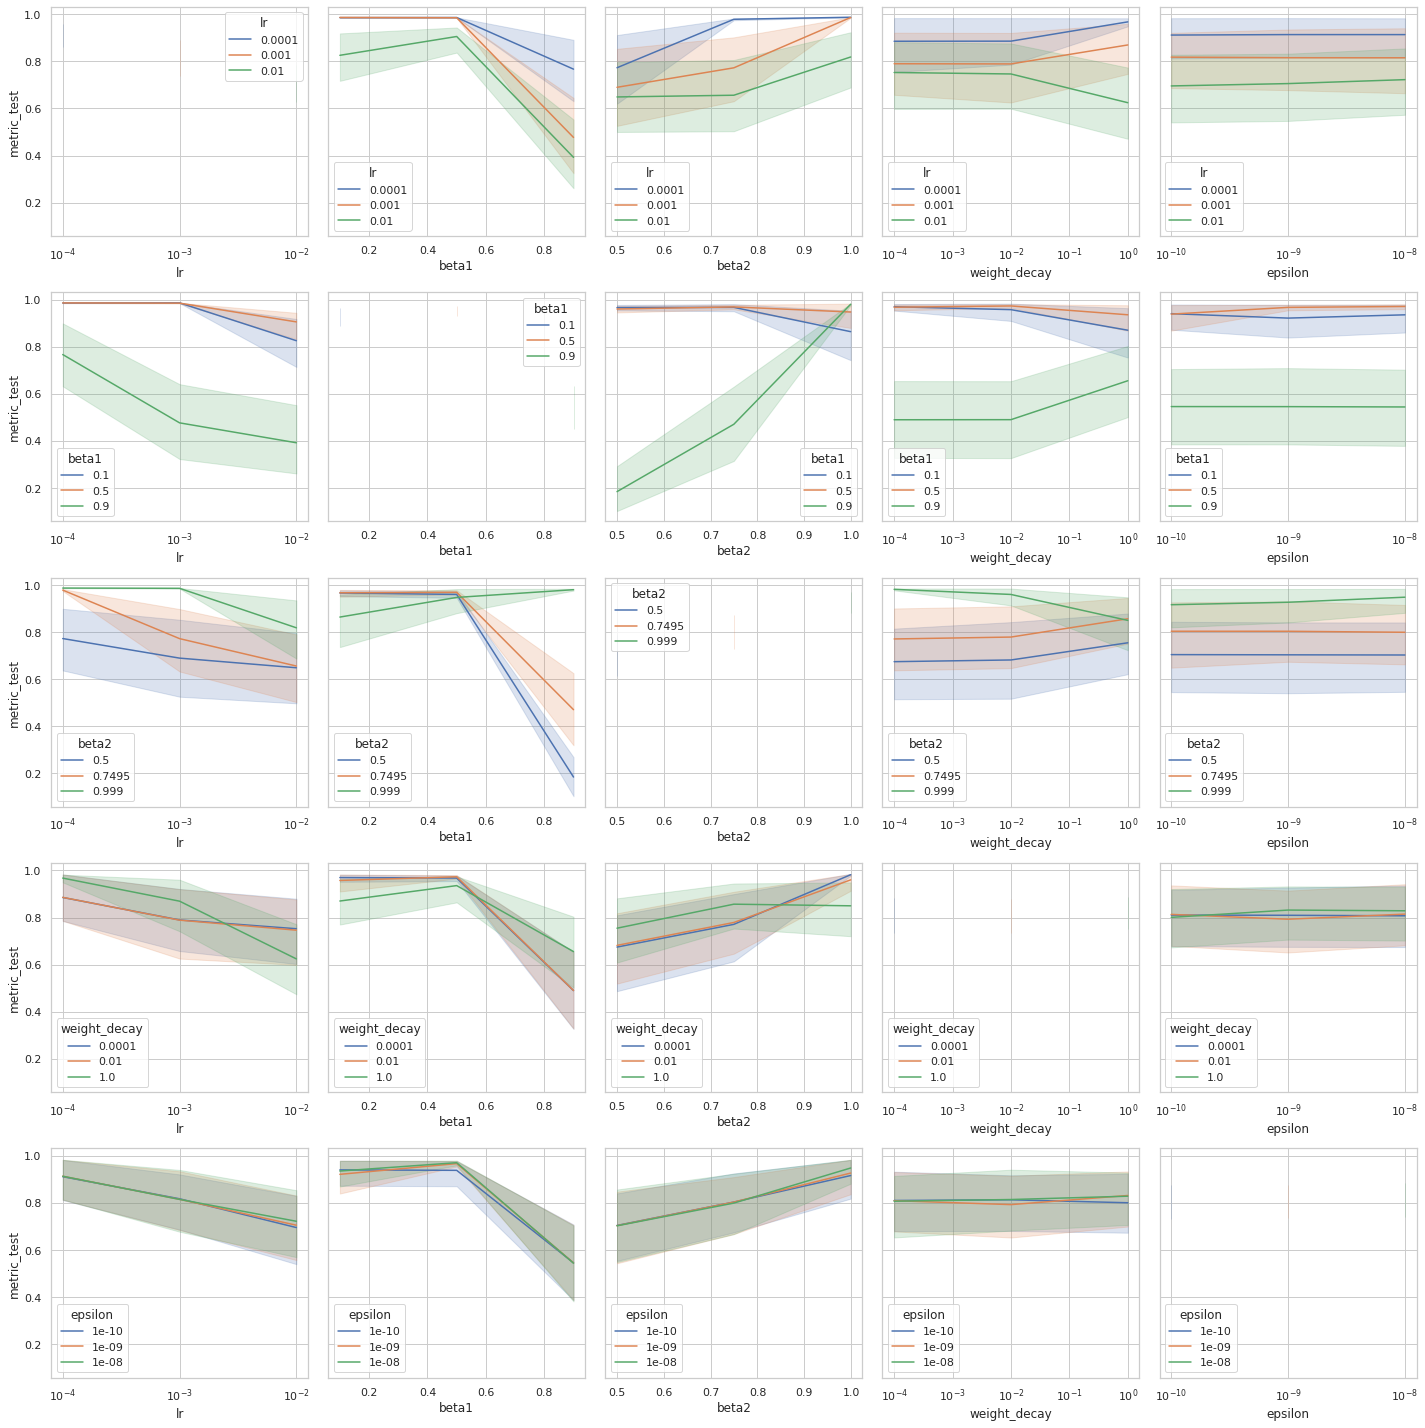

In [7]:
# Prepare figure
n = len(params)
fig, ax = plt.subplots(n, n, figsize=(4 * n, 4 * n), sharey=True)
colors = sns.color_palette()
logscale = ['lr', 'weight_decay', 'epsilon']

# Loop over all parameters
for p_hue, ax_row in zip(params, ax):
    ncol = df[p_hue].nunique()
    for p, a in zip(params, ax_row):
        sns.lineplot(x=p, y='metric_test', data=df, ax=a, hue=p_hue, palette=colors[:ncol])
        if p in logscale:
            a.set_xscale('log')
    
# Aesthetics
plt.tight_layout()

## Round 2

In [8]:
df, params = load_res_file('adam_tuning_round2')
df.shape, params

((27, 11), Index(['lr', 'weight_decay', 'batch_size'], dtype='object'))

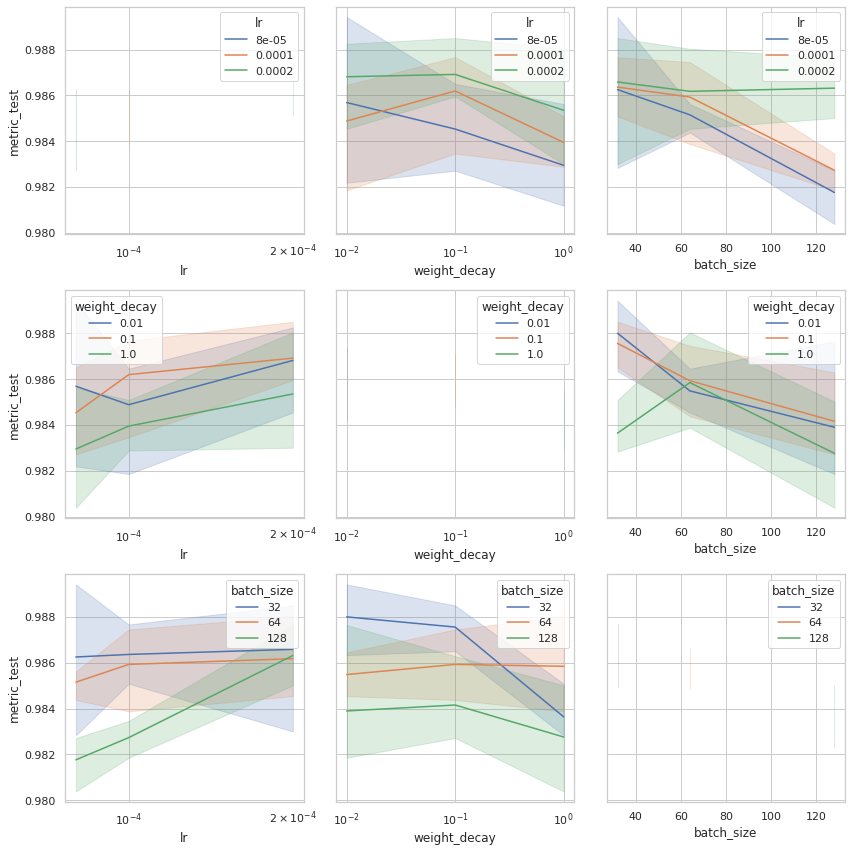

In [9]:
# Prepare figure
n = len(params)
fig, ax = plt.subplots(n, n, figsize=(4 * n, 4 * n), sharey=True)
colors = sns.color_palette()
logscale = ['lr', 'weight_decay', 'epsilon']

# Loop over all parameters
for p_hue, ax_row in zip(params, ax):
    ncol = df[p_hue].nunique()
    for p, a in zip(params, ax_row):
        sns.lineplot(x=p, y='metric_test', data=df, ax=a, hue=p_hue, palette=colors[:ncol])
        if p in logscale:
            a.set_xscale('log')
    
# Aesthetics
plt.tight_layout()

In [10]:
top_config = df.drop(columns=['loss_train', 'metric_train']).sort_values(['metric_test', 'metric_test_std'], ascending=False).head(10)
top_config.reset_index(drop=True, inplace=True)
top_config

,loss_test,metric_test,lr,beta1,beta2,weight_decay,epsilon,batch_size,metric_test_std
0,0.037175,0.989417,0.00008,0.9,0.999,0.01,1.000000e-08,32,0.0
1,0.043336,0.988500,0.00020,0.9,0.999,0.10,1.000000e-08,32,0.0
2,0.044568,0.988250,0.00020,0.9,0.999,0.01,1.000000e-08,32,0.0
3,0.041443,0.988032,0.00020,0.9,0.999,1.00,1.000000e-08,64,0.0
4,0.041631,0.987667,0.00010,0.9,0.999,0.10,1.000000e-08,32,0.0
5,0.040248,0.987644,0.00020,0.9,0.999,0.01,1.000000e-08,128,0.0
6,0.040772,0.987450,0.00010,0.9,0.999,0.10,1.000000e-08,64,0.0
7,0.047995,0.986500,0.00008,0.9,0.999,0.10,1.000000e-08,32,0.0
8,0.043595,0.986453,0.00010,0.9,0.999,0.01,1.000000e-08,64,0.0
9,0.055744,0.986333,0.00010,0.9,0.999,0.01,1.000000e-08,32,0.0


Note that most have essentially the same test accuracy (but, we have only 1 fold, so we don't know about standard deviation). Let's pick three configs out of this top 10, taking batch sizes 32, 64 and 128.

## Final round

In [11]:
df, params = load_res_file('adam_tuning_round3', drop_cst_param=False)
params

Index(['lr', 'beta1', 'beta2', 'weight_decay', 'epsilon', 'batch_size'], dtype='object')

In [12]:
df

,loss_train,metric_train,loss_test,metric_test,lr,beta1,beta2,weight_decay,epsilon,batch_size,metric_test_std
0,"[1.0042466789, 0.15668582718, 0.08859477959999...","[0.7158875, 0.9534958333200001, 0.97337916666,...",0.043293,0.98685,0.00008,0.9,0.999,0.01,1.000000e-08,32,0.000740
1,"[1.09300293552, 0.16590775091999999, 0.0949802...","[0.70200833334, 0.9517416666799999, 0.97167499...",0.043885,0.98617,0.00020,0.9,0.999,1.00,1.000000e-08,64,0.001233
2,"[1.7898071079799998, 0.31251854896, 0.15462662...","[0.4848958333200001, 0.9115999999800002, 0.954...",0.056118,0.98274,0.00020,0.9,0.999,0.01,1.000000e-08,128,0.002250


In [13]:
for idx, row in df.iterrows():
    print(f'idx={idx}{"":>10}train_acc={row.metric_train[-1]:.3}{"":>10}test_acc={row.metric_test:.3}{"":>10}test_acc_std={row.metric_test_std:.3}')

idx=0          train_acc=0.996          test_acc=0.987          test_acc_std=0.00074
idx=1          train_acc=0.991          test_acc=0.986          test_acc_std=0.00123
idx=2          train_acc=0.992          test_acc=0.983          test_acc_std=0.00225


The best config is clearly the first one : it has higher test accuracy and smallest std.

In [14]:
adam_best_params = df.iloc[0][params].to_dict()
adam_best_params

{'lr': 8e-05,
 'beta1': 0.9,
 'beta2': 0.999,
 'weight_decay': 0.01,
 'epsilon': 1e-08,
 'batch_size': 32}

# Nesterov Optimizer

## Coarse grid

In [16]:
df, params = load_res_file('nesterov_tuning_round1')
params, df.shape

(Index(['lr'], dtype='object'), (15, 6))

In [17]:
df

,loss_train,metric_train,loss_test,metric_test,lr,metric_test_std
0,5.120746e-01,0.861063,0.054394,0.982214,0.000010,0.0
1,3.804714e-01,0.896421,0.042827,0.986203,0.000019,0.0
2,2.841351e-01,0.922600,0.046351,0.985289,0.000037,0.0
3,2.135271e-01,0.940923,0.035676,0.988780,0.000072,0.0
4,1.615702e-01,0.955169,0.060882,0.985289,0.000139,0.0
5,1.290443e-01,0.963821,0.054467,0.986619,0.000268,0.0
6,1.188009e-01,0.967710,0.140025,0.976064,0.000518,0.0
7,2.812733e+01,0.749600,2.315832,0.097241,0.001000,0.0
8,NaN,0.498679,NaN,0.097906,0.001931,0.0
9,5.260000e+01,0.350154,2.303754,0.102144,0.003728,0.0


Some learning rates were so high that we did not even converge. We should not get the learning rate above $10^{-3}$. We rerun **with KFold** and varying batch size as well:

In [18]:
df, params = load_res_file('nesterov_tuning_round2')
params, df.shape

(Index(['lr', 'batch_size'], dtype='object'), (9, 7))

In [19]:
df

,loss_train,metric_train,loss_test,metric_test,lr,batch_size,metric_test_std
0,"[1.0362153348209957, 0.11705364113727894, 0.06...","[0.7064541666666667, 0.9643499999999999, 0.979...",0.070433,0.984483,0.00005,32,0.001781
1,"[1.7440423794845739, 0.3250394724443555, 0.129...","[0.5171749999999999, 0.9098291666666667, 0.960...",0.045489,0.987566,0.00005,64,0.001015
2,"[2.2462334739685064, 1.2425956624587378, 0.384...","[0.29422916666666665, 0.7464875, 0.8949, 0.936...",0.055020,0.983056,0.00005,128,0.001591
3,"[0.7894864935464071, 0.08743801613347993, 0.05...","[0.774675, 0.9727041666666667, 0.9834249999999...",0.132979,0.977867,0.00010,32,0.002969
4,"[1.349500105990718, 0.1873685463264895, 0.0841...","[0.622025, 0.9452708333333334, 0.9737666666666...",0.051376,0.986785,0.00010,64,0.002424
5,"[2.126051558812459, 0.5686669065495332, 0.2288...","[0.4042458333333333, 0.8562583333333335, 0.933...",0.048081,0.985766,0.00010,128,0.001152
6,"[0.4256313717435793, 0.08645664500425262, 0.12...","[0.8789583333333333, 0.9743458333333332, 0.967...",2.306588,0.102783,0.00050,32,0.008226
7,"[0.7070918336969491, 0.08119045995769751, 0.05...","[0.7982166666666666, 0.9747125000000001, 0.983...",0.206679,0.968152,0.00050,64,0.003867
8,"[1.226156854622563, 0.15295060119057696, 0.074...","[0.6563541666666667, 0.9541708333333334, 0.976...",0.053332,0.986547,0.00050,128,0.001384


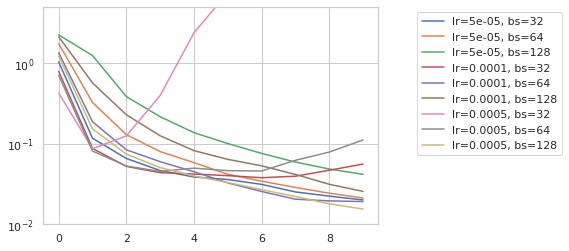

In [20]:
cols = sns.color_palette()
ncol = len(cols)

for i, row in df.sort_values('lr').iterrows():
    col = cols[i % ncol]
    ls = '-' if i < ncol else '--'
    plt.semilogy(row.loss_train, label=f'lr={row.lr:.3}, bs={row.batch_size}', color=col, ls=ls)
    
plt.ylim(bottom=1e-2, top=5)
plt.legend(bbox_to_anchor=(1.1,1));

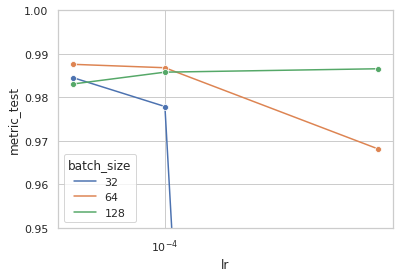

In [21]:
sns.lineplot(x='lr', y='metric_test', hue='batch_size', data=df, marker='o', palette=sns.color_palette()[:df.batch_size.nunique()])
plt.xscale('log')
plt.ylim(0.95, 1.0);

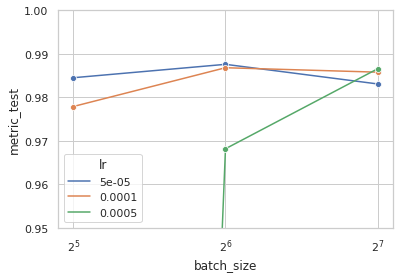

In [22]:
sns.lineplot(x='batch_size', y='metric_test', hue='lr', data=df, marker='o', palette=sns.color_palette()[:df.batch_size.nunique()])
plt.xscale('log', base=2)
plt.ylim(0.95, 1.0);

The best config seems batch size 64 and smallest learning rate, but let's check std:

In [23]:
df.sort_values('metric_test', ascending=False)

,loss_train,metric_train,loss_test,metric_test,lr,batch_size,metric_test_std
1,"[1.7440423794845739, 0.3250394724443555, 0.129...","[0.5171749999999999, 0.9098291666666667, 0.960...",0.045489,0.987566,0.00005,64,0.001015
4,"[1.349500105990718, 0.1873685463264895, 0.0841...","[0.622025, 0.9452708333333334, 0.9737666666666...",0.051376,0.986785,0.00010,64,0.002424
8,"[1.226156854622563, 0.15295060119057696, 0.074...","[0.6563541666666667, 0.9541708333333334, 0.976...",0.053332,0.986547,0.00050,128,0.001384
5,"[2.126051558812459, 0.5686669065495332, 0.2288...","[0.4042458333333333, 0.8562583333333335, 0.933...",0.048081,0.985766,0.00010,128,0.001152
0,"[1.0362153348209957, 0.11705364113727894, 0.06...","[0.7064541666666667, 0.9643499999999999, 0.979...",0.070433,0.984483,0.00005,32,0.001781
2,"[2.2462334739685064, 1.2425956624587378, 0.384...","[0.29422916666666665, 0.7464875, 0.8949, 0.936...",0.055020,0.983056,0.00005,128,0.001591
3,"[0.7894864935464071, 0.08743801613347993, 0.05...","[0.774675, 0.9727041666666667, 0.9834249999999...",0.132979,0.977867,0.00010,32,0.002969
7,"[0.7070918336969491, 0.08119045995769751, 0.05...","[0.7982166666666666, 0.9747125000000001, 0.983...",0.206679,0.968152,0.00050,64,0.003867
6,"[0.4256313717435793, 0.08645664500425262, 0.12...","[0.8789583333333333, 0.9743458333333332, 0.967...",2.306588,0.102783,0.00050,32,0.008226


It has the smallest std as well !

In [24]:
nesterov_best_config = df.loc[1][params].to_dict()
nesterov_best_config

{'lr': 5e-05, 'batch_size': 64}